## Analysis of drug response log(IC50) regression with held-out cancer types

In [1]:
import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pancancer_evaluation.config as cfg
import pancancer_evaluation.utilities.analysis_utilities as au

%load_ext autoreload
%autoreload 2

In [36]:
# analysis of results generated by script:
# 08_cell_line_classification/run_drug_response_prediction.py
# (with varying feature_selection parameters)

# we ran two types of experiments, one where we hold out each individual
# cancer type in CCLE and one where we pool liquid cancers and solid cancers
# and hold them out together
# here, we can choose which experiment we want to look at the results of
stratify_by = 'cancer_type'
if stratify_by == 'cancer_type':
    single_cancer_dir = os.path.join('results', 'drug_response_regression_drop_liquid', 'single_cancer')
    pancancer_dir = os.path.join('results', 'drug_response_regression_drop_liquid', 'pancancer')
    pancancer_only_dir = os.path.join('results', 'drug_response_regression_drop_liquid', 'all_other_cancers')
elif stratify_by == 'liquid_or_solid':
    single_cancer_dir = os.path.join('results', 'drug_response_regression_liquid_or_solid', 'single_cancer')
    pancancer_dir = os.path.join('results', 'drug_response_regression_liquid_or_solid', 'pancancer')
    pancancer_only_dir = os.path.join('results', 'drug_response_regression_liquid_or_solid', 'all_other_cancers')

# feature selection dimensions tested
if stratify_by == 'cancer_type':
    # TODO run cancer type analyses for higher dimensions
    n_dims = [100, 250]
else:
    n_dims = [100, 250, 500, 1000, 5000]

# feature selection methods tested
fs_methods = [
    'mad',
    'pancan_f_test',
    'median_f_test',
    'random'
]

# drug to plot results for
drug = 'Docetaxel'

# metric to plot results for
# for regression this is one of 'rmse', 'r2', 'pearson', 'spearman'
metric = 'spearman'
use_delta_metric = False

# location to save plots to
output_plots = False
output_plots_dir = cfg.ccle_fs_plots_dir / 'drug_response_regression_{}'.format(stratify_by)

In [3]:
delta_metric = 'delta_{}'.format(metric)

### Load results

We load the results of the single cancer, pan-cancer, and "pan-cancer only" (aka "all other cancers") experiments here.

In [4]:
single_cancer_df = au.load_prediction_results_fs(
    single_cancer_dir, cfg.fs_methods, classify=False,
    identifier_from_fname=True, holdout_from_fname=True
)
single_cancer_df = single_cancer_df[single_cancer_df.n_dims.isin(n_dims)].copy()
single_cancer_df['train_set'] = 'single_cancer'

for n in n_dims:
    for fs_method in fs_methods:
        single_cancer_df.loc[
            (single_cancer_df.fs_method == fs_method) &
            (single_cancer_df.n_dims == n),
            'fs_method'
        ] = '{}.{}'.format(fs_method, n)

single_cancer_df.rename(columns={'identifier': 'drug', 'fold_no': 'fold'}, inplace=True)

print(np.unique(single_cancer_df.seed))
print(np.unique(single_cancer_df.n_dims))
print(np.unique(single_cancer_df.fs_method))
print(single_cancer_df.shape)
single_cancer_df.head()

[ 1 42]
[100 250]
['mad.100' 'mad.250' 'median_f_test.100' 'median_f_test.250'
 'pancan_f_test.100' 'pancan_f_test.250' 'random.100' 'random.250']
(40704, 14)


,mse,rmse,r2,pearson,spearman,data_type,drug,signal,seed,fold,fs_method,n_dims,holdout_cancer_type,train_set
0,3.563200e-17,5.969200e-09,1.00000,1.00000,1.00000,train,Erlotinib,signal,1,0,pancan_f_test.100,100,Neuroblastoma,single_cancer
1,1.230700e-01,3.508200e-01,0.88675,0.99402,0.88571,cv,Erlotinib,signal,1,0,pancan_f_test.100,100,Neuroblastoma,single_cancer
2,5.058000e-01,7.112000e-01,-8.62040,0.78467,1.00000,test,Erlotinib,signal,1,0,pancan_f_test.100,100,Neuroblastoma,single_cancer
3,2.925200e-17,5.408500e-09,1.00000,1.00000,1.00000,train,Erlotinib,signal,1,1,pancan_f_test.100,100,Neuroblastoma,single_cancer
4,2.541500e-01,5.041300e-01,0.74871,0.98428,0.75000,cv,Erlotinib,signal,1,1,pancan_f_test.100,100,Neuroblastoma,single_cancer


In [5]:
pancancer_df = au.load_prediction_results_fs(
    pancancer_dir, cfg.fs_methods, classify=False,
    identifier_from_fname=True, holdout_from_fname=True
)
pancancer_df = pancancer_df[pancancer_df.n_dims.isin(n_dims)].copy()
pancancer_df['train_set'] = 'pancancer'

for n in n_dims:
    for fs_method in fs_methods:
        pancancer_df.loc[
            (pancancer_df.fs_method == fs_method) & (pancancer_df.n_dims == n),
            'fs_method'
        ] = '{}.{}'.format(fs_method, n)
        
pancancer_df.rename(columns={'identifier': 'drug', 'fold_no': 'fold'}, inplace=True)

print(np.unique(pancancer_df.seed))
print(np.unique(pancancer_df.fs_method))
print(pancancer_df.shape)
pancancer_df.head()

[ 1 42]
['mad.100' 'mad.250' 'median_f_test.100' 'median_f_test.250'
 'pancan_f_test.100' 'pancan_f_test.250' 'random.100' 'random.250']
(40704, 14)


,mse,rmse,r2,pearson,spearman,data_type,drug,signal,seed,fold,fs_method,n_dims,holdout_cancer_type,train_set
0,1.0598,1.0295,0.37320,0.63138,0.49958,train,Erlotinib,signal,1,0,pancan_f_test.100,100,Neuroblastoma,pancancer
1,1.2830,1.1327,0.24118,0.49545,0.39492,cv,Erlotinib,signal,1,0,pancan_f_test.100,100,Neuroblastoma,pancancer
2,1.0310,1.0154,-18.61000,0.45648,0.50000,test,Erlotinib,signal,1,0,pancan_f_test.100,100,Neuroblastoma,pancancer
3,1.0513,1.0253,0.37676,0.63415,0.50560,train,Erlotinib,signal,1,1,pancan_f_test.100,100,Neuroblastoma,pancancer
4,1.2713,1.1275,0.24636,0.50097,0.40777,cv,Erlotinib,signal,1,1,pancan_f_test.100,100,Neuroblastoma,pancancer


In [6]:
pancancer_only_df = au.load_prediction_results_fs(
    pancancer_only_dir, cfg.fs_methods, classify=False,
    identifier_from_fname=True, holdout_from_fname=True
)
pancancer_only_df = pancancer_only_df[pancancer_only_df.n_dims.isin(n_dims)].copy()
pancancer_only_df['train_set'] = 'pancancer_only'

for n in n_dims:
    for fs_method in fs_methods:
        pancancer_only_df.loc[
            (pancancer_only_df.fs_method == fs_method) & (pancancer_only_df.n_dims == n),
            'fs_method'
        ] = '{}.{}'.format(fs_method, n)
        
pancancer_only_df.rename(columns={'identifier': 'drug', 'fold_no': 'fold'}, inplace=True)

print(np.unique(pancancer_only_df.seed))
print(np.unique(pancancer_only_df.fs_method))
print(pancancer_only_df.shape)
pancancer_only_df.head()

[ 1 42]
['mad.100' 'mad.250' 'median_f_test.100' 'median_f_test.250'
 'pancan_f_test.100' 'pancan_f_test.250' 'random.100' 'random.250']
(40704, 14)


,mse,rmse,r2,pearson,spearman,data_type,drug,signal,seed,fold,fs_method,n_dims,holdout_cancer_type,train_set
0,1.0594,1.0293,0.38331,0.64114,0.48110,train,Erlotinib,signal,1,0,pancan_f_test.100,100,Neuroblastoma,pancancer_only
1,1.2920,1.1367,0.24796,0.50178,0.36919,cv,Erlotinib,signal,1,0,pancan_f_test.100,100,Neuroblastoma,pancancer_only
2,1.0595,1.0293,-19.15300,0.45348,0.50000,test,Erlotinib,signal,1,0,pancan_f_test.100,100,Neuroblastoma,pancancer_only
3,1.0594,1.0293,0.38331,0.64114,0.48110,train,Erlotinib,signal,1,1,pancan_f_test.100,100,Neuroblastoma,pancancer_only
4,1.2920,1.1367,0.24796,0.50178,0.36919,cv,Erlotinib,signal,1,1,pancan_f_test.100,100,Neuroblastoma,pancancer_only


In [7]:
if use_delta_metric:
    # get difference between true and shuffled models, split by
    # feature selection method and holdout cancer type
    def compare_from_experiment(experiment_df):
        compare_df = []
        for fs_method in experiment_df.fs_method.unique():
            for holdout_cancer_type in experiment_df.holdout_cancer_type.unique():
                compare_df.append(
                    au.compare_control_ind(
                        experiment_df[
                            (experiment_df.fs_method == fs_method) &
                            (experiment_df.holdout_cancer_type == holdout_cancer_type)
                        ], identifier='drug', metric=metric, verbose=True)
                      .assign(fs_method=fs_method,
                              holdout_cancer_type=holdout_cancer_type)
                      .rename(columns={'identifier': 'drug'})
                )
        return pd.concat(compare_df)

    single_cancer_compare_df = compare_from_experiment(single_cancer_df)
    pancancer_compare_df = compare_from_experiment(pancancer_df)
    pancancer_only_compare_df = compare_from_experiment(pancancer_only_df)
    metric = delta_metric
else:
    # just use metric for true models and ignore shuffled baseline
    # filter to unshuffled results on test datasets only
    single_cancer_compare_df = (single_cancer_df[
        (single_cancer_df.signal == 'signal') &
        (single_cancer_df.data_type == 'test')
    ].copy())
    pancancer_compare_df = (pancancer_df[
        (pancancer_df.signal == 'signal') &
        (pancancer_df.data_type == 'test')
    ].copy())
    pancancer_only_compare_df = (pancancer_only_df[
        (pancancer_only_df.signal == 'signal') &
        (pancancer_only_df.data_type == 'test')
    ].copy())

print(single_cancer_compare_df.shape,
      pancancer_compare_df.shape,
      pancancer_only_compare_df.shape)

single_cancer_compare_df.head()

(6784, 14) (6784, 14) (6784, 14)


,mse,rmse,r2,pearson,spearman,data_type,drug,signal,seed,fold,fs_method,n_dims,holdout_cancer_type,train_set
2,0.50580,0.71120,-8.62040,0.78467,1.00000,test,Erlotinib,signal,1,0,pancan_f_test.100,100,Neuroblastoma,single_cancer
5,0.44002,0.66334,-3.62130,-1.00000,-1.00000,test,Erlotinib,signal,1,1,pancan_f_test.100,100,Neuroblastoma,single_cancer
8,0.11967,0.34593,0.27542,1.00000,1.00000,test,Erlotinib,signal,1,2,pancan_f_test.100,100,Neuroblastoma,single_cancer
11,3.89490,1.97350,-2.41750,1.00000,1.00000,test,Erlotinib,signal,1,3,pancan_f_test.100,100,Neuroblastoma,single_cancer
2,1.12270,1.05960,-1.24810,-0.31290,-0.38333,test,Erlotinib,signal,1,0,pancan_f_test.250,250,Lung,single_cancer


In [8]:
# split fs_method and n_dims so we can make a line plot
# over different values of n_dims
for compare_df in [
    single_cancer_compare_df,
    pancancer_compare_df,
    pancancer_only_compare_df
]:
    compare_df[['fs_method', 'n_dims']] = compare_df.fs_method.str.split('.', 1, expand=True)
    compare_df['n_dims'] = compare_df.n_dims.astype(int)

In [9]:
print(single_cancer_compare_df.fs_method.unique())
print(single_cancer_compare_df.n_dims.unique())
single_cancer_compare_df.head()

['pancan_f_test' 'median_f_test' 'random' 'mad']
[100 250]


,mse,rmse,r2,pearson,spearman,data_type,drug,signal,seed,fold,fs_method,n_dims,holdout_cancer_type,train_set
2,0.50580,0.71120,-8.62040,0.78467,1.00000,test,Erlotinib,signal,1,0,pancan_f_test,100,Neuroblastoma,single_cancer
5,0.44002,0.66334,-3.62130,-1.00000,-1.00000,test,Erlotinib,signal,1,1,pancan_f_test,100,Neuroblastoma,single_cancer
8,0.11967,0.34593,0.27542,1.00000,1.00000,test,Erlotinib,signal,1,2,pancan_f_test,100,Neuroblastoma,single_cancer
11,3.89490,1.97350,-2.41750,1.00000,1.00000,test,Erlotinib,signal,1,3,pancan_f_test,100,Neuroblastoma,single_cancer
2,1.12270,1.05960,-1.24810,-0.31290,-0.38333,test,Erlotinib,signal,1,0,pancan_f_test,250,Lung,single_cancer


### Plot average performance across cancer types and number of features selected

In [25]:
print(single_cancer_compare_df.drug.unique())

['Erlotinib' 'Paclitaxel' 'Gemcitabine' 'Cetuximab' 'Tamoxifen'
 'Docetaxel' 'Cisplatin']


In [26]:
print(single_cancer_compare_df.fs_method.unique())

['pancan_f_test' 'median_f_test' 'random' 'mad']


['Ovarian' 'Bladder' 'Cervical' 'Pancreatic' 'Breast' 'Brain'
 'Endometrial' 'Esophageal' 'Thyroid' 'Kidney' 'Neuroblastoma' 'Lung'
 'Gastric' 'Liver' 'Skin' 'Bone' 'Colon' 'Sarcoma' 'Head']


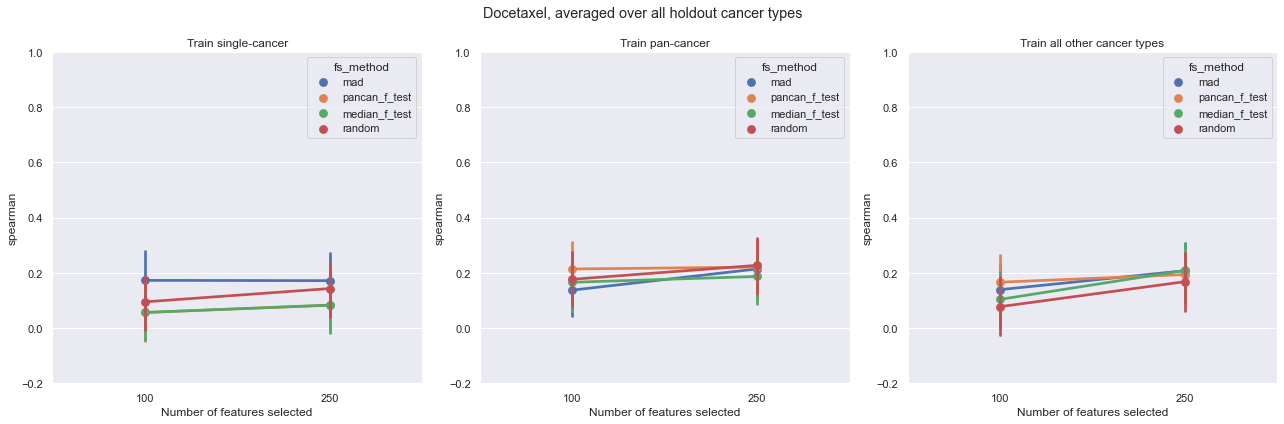

In [37]:
sns.set({'figure.figsize': (18, 6)})
sns.set_context('notebook')

fig, axarr = plt.subplots(1, 3)

dfs_to_plot = [
    single_cancer_compare_df,
    pancancer_compare_df,
    pancancer_only_compare_df
]

names_to_plot = [
    'Train single-cancer',
    'Train pan-cancer',
    'Train all other cancer types'
]

fs_method_order = [
    'mad',
    'pancan_f_test',
    'median_f_test',
    'random'
]


for ix, compare_df in enumerate(dfs_to_plot):
    ax = axarr[ix]
    # averaged over cancer types
    plot_df = (compare_df[(compare_df.drug == drug)]
      .sort_values(by='n_dims', ascending=True)
    )
    sns.pointplot(data=plot_df, x='n_dims', y=metric, hue='fs_method',
                  hue_order=fs_method_order, ax=ax)
    ax.set_title(names_to_plot[ix])
    ax.set_xlabel('Number of features selected')
    ax.set_ylim(-0.2, 1)
    
plt.suptitle('{}, averaged over all holdout cancer types'.format(drug))
plt.tight_layout()

print(plot_df.holdout_cancer_type.unique(), file=sys.stderr)

if output_plots:
    output_plots_dir.mkdir(exist_ok=True)
    plt.savefig(output_plots_dir / '{}_{}_response_classify_summary.png'.format(drug, metric),
                dpi=200, bbox_inches='tight')

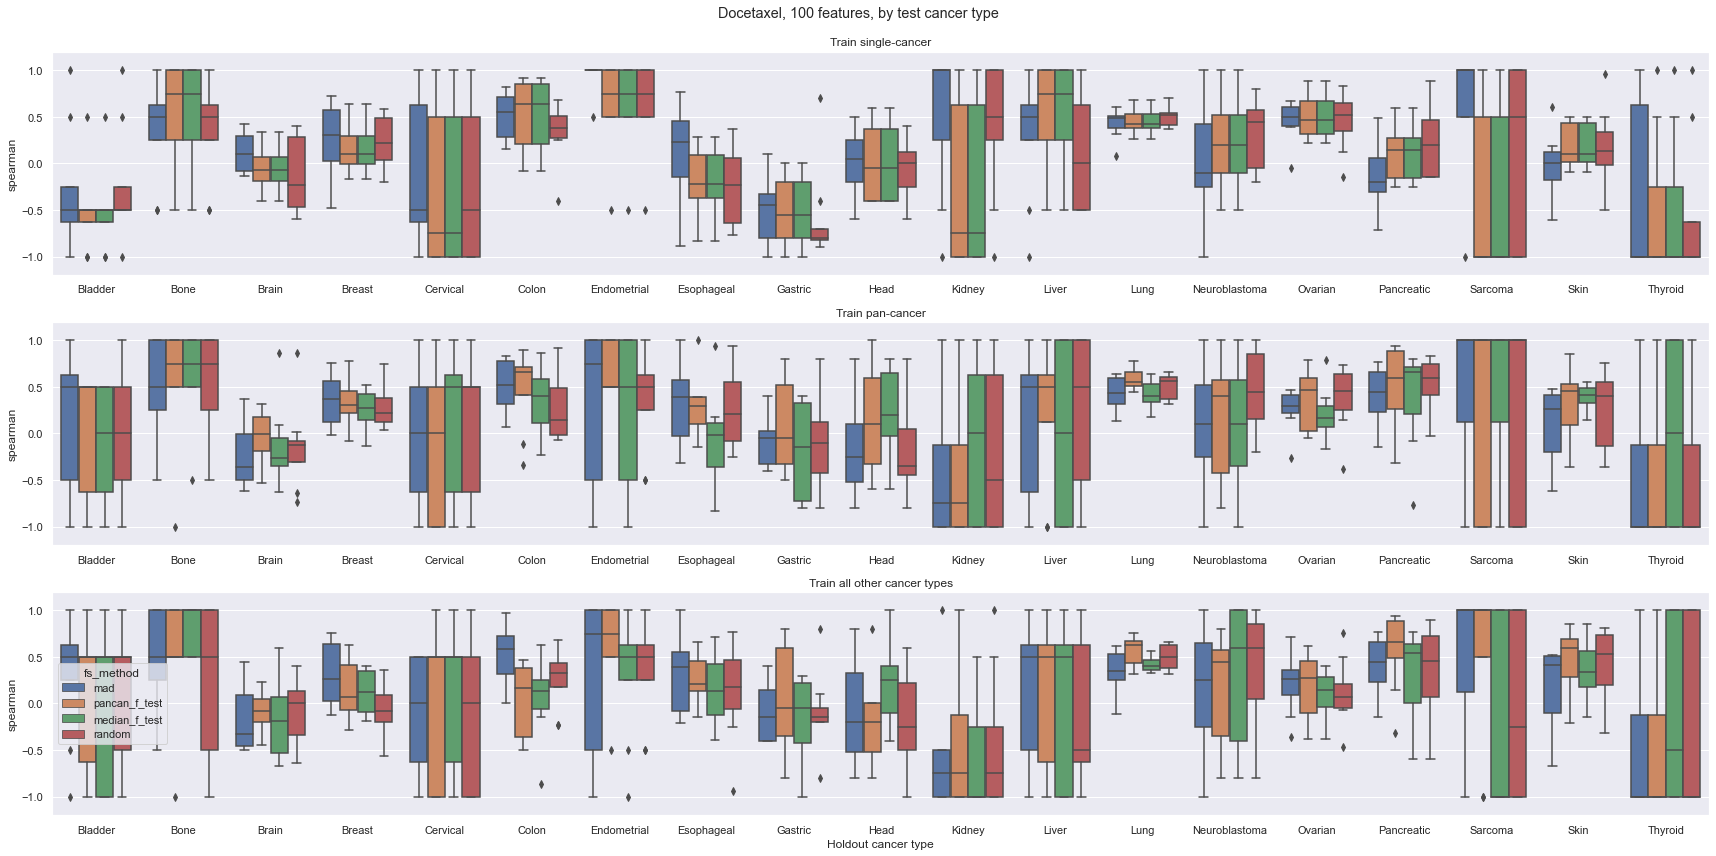

In [38]:
sns.set({'figure.figsize': (24, 12)})
sns.set_context('notebook')

fig, axarr = plt.subplots(3, 1)

dfs_to_plot = [
    single_cancer_compare_df,
    pancancer_compare_df,
    pancancer_only_compare_df
]

names_to_plot = [
    'Train single-cancer',
    'Train pan-cancer',
    'Train all other cancer types'
]

# max_n_dims = max(n_dims)
max_n_dims = 100

# split individual cancer types
for ix, compare_df in enumerate(dfs_to_plot):
    ax = axarr[ix]
    plot_df = (compare_df[(compare_df.drug == drug) &
                          (compare_df.n_dims == max_n_dims)]
      .sort_values(by='holdout_cancer_type')
    )
    sns.boxplot(data=plot_df, x='holdout_cancer_type', 
                y=metric, hue='fs_method', 
                hue_order=fs_method_order, ax=ax)
    ax.set_title(names_to_plot[ix])
    if ix == len(dfs_to_plot) - 1:
        ax.set_xlabel('Holdout cancer type')
    else:
        ax.set_xlabel('')
        ax.get_legend().remove()
    ax.set_ylim(-1.2, 1.2)
    
plt.suptitle('{}, {} features, by test cancer type'.format(drug, max_n_dims), y=0.99)
plt.tight_layout()

if output_plots:
    plt.savefig(output_plots_dir / '{}_{}_response_classify_by_cancer_type.png'.format(drug, metric),
                dpi=200, bbox_inches='tight')